# Strategy Evalution for Rolling Dice in 3 Rounds

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode, wilcoxon

## Game Definitions

The objective of the game is to score the highest pips by rolling a number (`num_dice`) of dice. The dice can be rolled up to `num_trials` trials. After each trial, the player can choose to keep a subset of the dice and reroll the rest.

In [2]:
num_dice = 5
num_trials = 3

## Strategic Consideration

In the case of only one trial `num_trials=1` there is no choice. Since the dice outcomes are independent from eachother, the expected outcome is `num_dice` times $\mu_1=3.5$ (expected value of a die).

Recursively, for each more number of trials, the player may choose to keep the dice with higher number of dots than the expected value of rerolling.

For a second trial that means, keeping all dice with 4 or more dots. That results in an expected value of $\mu_{2|4}=\frac 1 2 (\frac {4+5+6} 3)+ \frac 1 2 \mu_1=4.25$.

For the third trial that means, keeping all dice with 5 or more dots (since $4<\mu_{2|4}$). The expected value is
$\mu_{2|5\_4}=\frac 1 3 (\frac {5+6} 2)+ \frac 2 3 \mu_{2|4}=4.\bar{6}$.

## Monte Carlo Simulation

In this section, we run simulations to compare some strategy. The Monto Carlo simulations not just allow us to confirm the expected value, but also estimate easily different moments of the distribution.

In [3]:
num_simulations = 100000

In [4]:
def monte_carlo_dice_rolls(sel_strategy, num_simulations=num_simulations):
    """Runs a Monte Carlo simulation for a given selection strategy for rolling dice.

    The game consists of `num_trials` trials, in which dice are rolled. After rolling the dice,
    the choice is which dice to keep (and count the pips) and which to reroll (and discard the pips).
    This choice is represented through the selection strategy `sel_strategy`. Dice of the last run are all kept.

    Args:
        sel_strategy (function): function that accepts an array of
            pips and the trial and returns a boolean array indicating
            which die to keep.
        num_simulations (int): rounds of monto carlo simulations

    Returns:
        np.array: array of results of each monto carlo simulation.
    """
    outcomes = []
    for _ in range(num_simulations):
        num_dice_reroll = num_dice
        total_pips = 0
        for i in range(num_trials):
            dice = np.array([random.randint(1, 6) for _ in range(num_dice_reroll)])
            if i == num_trials - 1: # last trial
                mask = dice > 0
            else:
                mask = sel_strategy(dice, i+1)
            total_pips += sum(dice[mask])
            num_dice_kept = sum(mask)
            num_dice_reroll -= num_dice_kept
        outcomes.append(total_pips)
    return np.array(outcomes)

In [5]:
def sel_strategy_4(dice_pips, trial):
    """Implements the keep 4+ pips strategy.

    This strategy keeps all dice with more than 3 pips.

    Args:
        dice_pips (np.array): outcome of each die roll
        trial (int): number of trial

    Returns:
        np.array: boolean corresponding to which dice to keep
    """

    if trial == 1:
        return dice_pips > 3
    return dice_pips > 3

res_4 = monte_carlo_dice_rolls(sel_strategy_4)

In [6]:
def sel_strategy_5_4(dice_pips, trial):
    """Implements the keep 5+/4+ pips strategy.

    This strategy keeps in the first run all dice with more than 4 pips and in the subsequent runs
    all dice with more than 3 pips.

    Args:
        dice_pips (np.array): outcome of each die roll
        trial (int): number of trial

    Returns:
        np.array: boolean corresponding to which dice to keep
    """
    if trial == 1:
        return dice_pips > 4
    return dice_pips > 3

res_5_4 = monte_carlo_dice_rolls(sel_strategy_5_4)

In [7]:
def sel_strategy_5_4_flex(dice_pips, trial):
    """Implements an alternative to the keep 5+/4+ pips strategy.

    This strategy keeps in the first run all dice with more than 4 pips and in the subsequent runs
    all dice with more than 3 pips. If in the first trial there are no dice with 5+ pips, it would also
    keep the 4s.

    Args:
        dice_pips (np.array): outcome of each die roll
        trial (int): number of trial

    Returns:
        np.array: boolean corresponding to which dice to keep
    """
    if trial == 1:
        mask = dice_pips > 4
        if any(mask):
            return mask
    return dice_pips > 3

res_5_4_flex = monte_carlo_dice_rolls(sel_strategy_5_4_flex)

## Evaluation

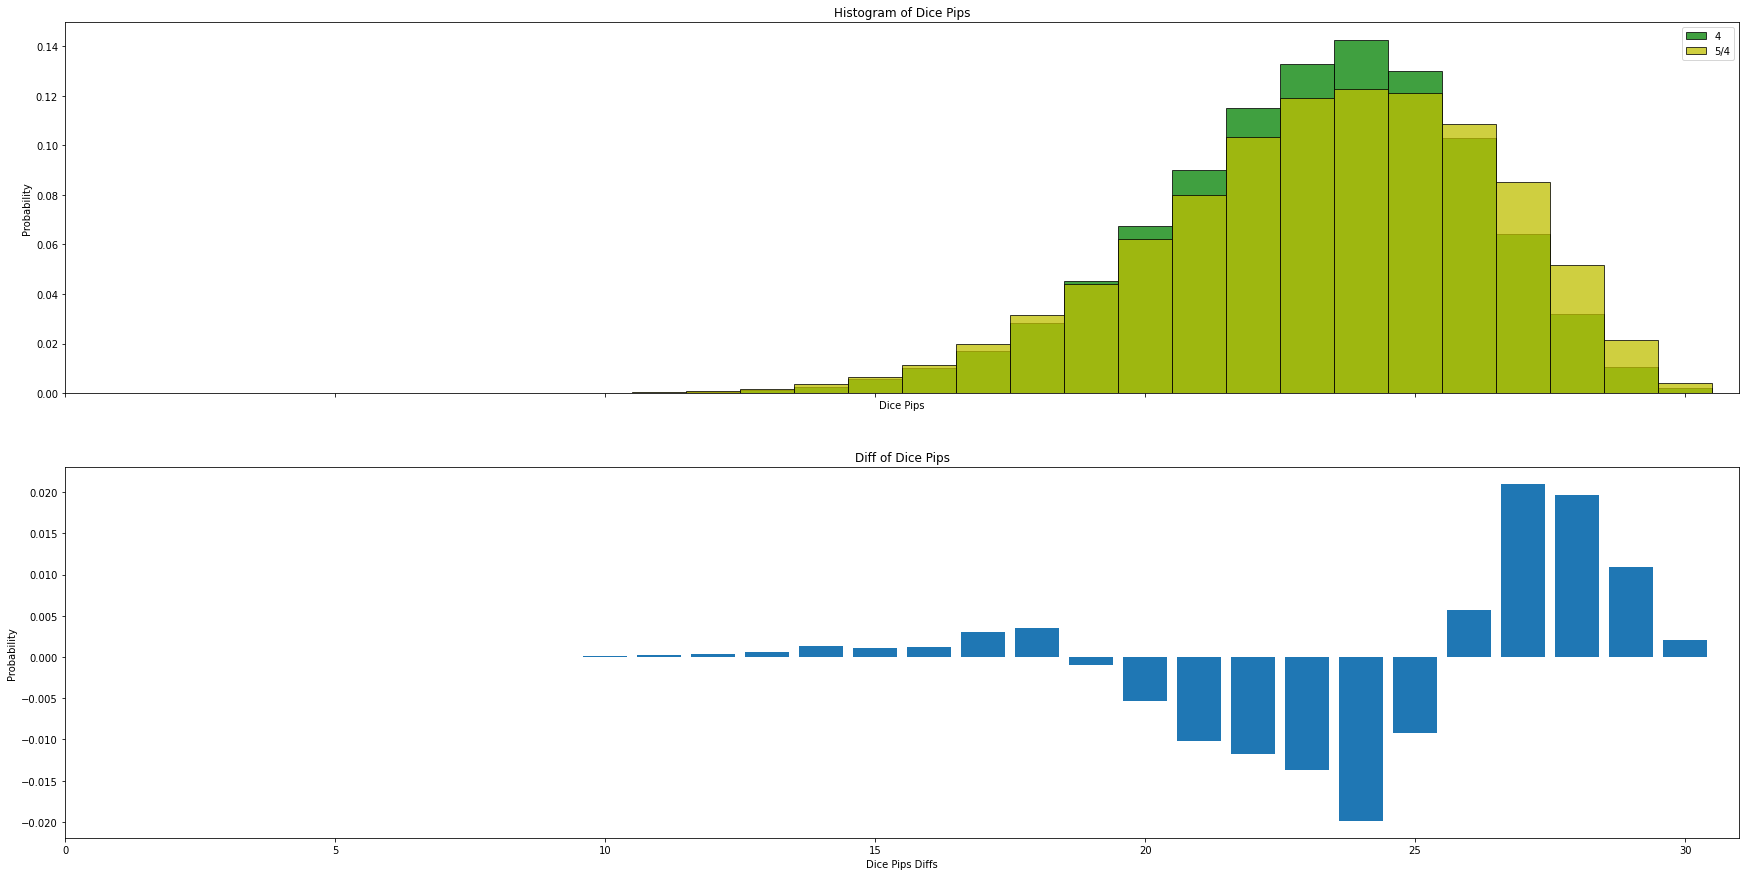

In [13]:
bins = np.arange(30)+1.5

_, ax = plt.subplots(2, 1, sharex=True, figsize=(30,15))
ax[0].hist(res_4, bins, density=True, facecolor='g', alpha=0.75, edgecolor='black')
ax[0].hist(res_5_4, bins, density=True, facecolor='y', alpha=0.75, edgecolor='black')
ax[0].set_xlabel('Dice Pips');
ax[0].set_ylabel('Probability');
ax[0].set_title('Histogram of Dice Pips');
ax[0].set_xlim([0, 31]);
ax[0].legend(['4', '5/4'])

ax[1].bar(
    bins[1:]-0.5,
    np.histogram(res_5_4, bins=bins, density=True)[0]-np.histogram(res_4, bins=bins, density=True)[0]
)
ax[1].set_xlabel('Dice Pips Diffs');
ax[1].set_ylabel('Probability');
ax[1].set_title('Diff of Dice Pips');
ax[1].set_xlim([0, 31]);



In [9]:
def print_stats(res):
    print(f"""
        Mean: {np.mean(res)}
        Mode: {mode(res, keepdims=True).mode}
        25th and 75th percentile: {np.percentile(res, [25,75])}
    """)

print_stats(res_4)
print_stats(res_5_4)


        Mean: 23.1282
        Mode: [24]
        25th and 75th percentile: [21. 25.]
    

        Mean: 23.33989
        Mode: [24]
        25th and 75th percentile: [21. 26.]
    


# Statistical Tests: Is the Strategy Signficantly Better?

In [10]:
wilcoxon(
    x=res_4, y=res_5_4,
    zero_method='wilcox', # ignore ties
    
)

WilcoxonResult(statistic=1908062558.0, pvalue=1.101171214852445e-65)

The strategy to keep dice with more than 4 dots in the first trial and dice with more than 3 dots in the second trial is superior over keeping always dice with more than 3 dots.